In [45]:
import torch
import matplotlib.pyplot as plt
import math
import os
from torch.utils.data import TensorDataset, random_split, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR, MultiStepLR
from torch import nn
import torch.nn.functional as F
import numpy as np
import optuna


In [46]:
torch.cuda.is_available()

False

### Génération du dataset d'inputs/outputs

In [47]:
input = (torch.rand(10000, 5))*10
n = input.size(1)

# Calcul de la moyenne et de l'écart-type
moment1 = torch.mean(input, dim=1, keepdim=True)
std_dev = torch.std(input, dim=1, keepdim=True)

# Normalisation des données par rapport à la moyenne et division par l'écart-type
normalized_data = (input - moment1) / std_dev

# Calcul de la skewness
skewness = (torch.sum((normalized_data ** 3), dim=1) * (n / ((n - 1) * (n - 2)))).unsqueeze(1)

# Calcul de la kurtosis (avec la correction pour utiliser l'écart-type)
kurtosis = ((n * (n + 1) / ((n - 1) * (n - 2) * (n - 3))) *
            torch.sum((normalized_data ** 4), dim=1) -
            (3 * (n - 1) ** 2) / ((n - 2) * (n - 3))).unsqueeze(1)

# Création du tenseur de sortie qui contient les 4 moments
output = torch.cat((moment1, std_dev ** 2, skewness, kurtosis), dim=1)

# Création d'un TensorDataset
dataset = TensorDataset(input, output)

In [48]:
# Tailles des ensembles d'entraînement, de validation et de test
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size
# Diviser le dataset
train_set, valid_set, test_set = random_split(dataset, [train_size, valid_size, test_size])

In [49]:
# Créer des DataLoader pour chaque ensemble

batch_size = 64

train_loader = DataLoader(train_set, batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

### Modèles

In [83]:
############## FEEDFORWARD ####################

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(in_features=len(input[1, :]), out_features=64) 
        self.fc2 = nn.Linear(64, 64)  
        self.fc3 = nn.Linear(64, 4)  

    def forward(self, x):
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x))  
        x = self.fc3(x) 
        return x

class SecondModel(nn.Module):
    def __init__(self, width, depth):
        super(SecondModel, self).__init__()
        self.fc1 = nn.Linear(in_features=len(input[1, :]), out_features = width) 
        self.layers = nn.ModuleList([nn.Linear(in_features=width, out_features=width) for i in range(depth)])
        self.fcfinal = nn.Linear(width, 4)  

    def forward(self, x):
        x = F.relu(self.fc1(x))  
        for layer in self.layers:
            x = layer(x)
        x = self.fcfinal(x) 
        return x

################### RESNET ######################

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(in_features, in_features)
        self.bn1 = nn.BatchNorm1d(in_features)
        self.fc2 = nn.Linear(in_features, in_features)
        self.bn2 = nn.BatchNorm1d(in_features)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.fc1(x)))
        out = self.bn2(self.fc2(out))
        out += residual
        return F.relu(out)

class SimpleResNet(nn.Module):
    def __init__(self, width, depth):
        super(SimpleResNet, self).__init__()
        self.fc_in = nn.Linear(len(input[1, :]), width) 
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(width) for _ in range(depth)]
        )
        self.fc_out = nn.Linear(width, 4)  

    def forward(self, x):
        x = F.relu(self.fc_in(x))
        x = self.res_blocks(x)
        x = self.fc_out(x)
        return x

################### TRANSFORMER ####################

class TransformerModel(nn.Module):
    def __init__(self, input_size=5, output_size=4, nhead=16, nhid=256, nlayers=5, dropout=0.1, embed_dim = 128):
        ########### EMBED DIM MUST BE DIVISIBLE BY N_HEAD
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'

        # Adjusted embedding dimension to be divisible by nhead
        self.pos_encoder = PositionalEncoding(embed_dim, dropout)
        encoder_layers = TransformerEncoderLayer(embed_dim, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)

        # Additional layer to project input to the new embedding dimension
        self.input_projection = nn.Linear(input_size, embed_dim)

        self.encoder = nn.Linear(embed_dim, embed_dim)
        self.ninp = embed_dim
        self.decoder = nn.Linear(embed_dim, output_size)

    def forward(self, src):
        src = self.input_projection(src)  # Project input to embedding dimension
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        output = output.mean(dim=0)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

### Fonction d'entraînement

In [75]:
def train(hyperparameters):

    lr = hyperparameters['lr']
    weight_decay = hyperparameters['weight_decay']
    step_size = hyperparameters['step_size']
    gamma = hyperparameters['gamma']
    width = hyperparameters['width']
    depth = hyperparameters['depth']
    
    #model = SecondModel(width, depth)
    #model = SimpleResNet(width, depth)
    model = TransformerModel()

    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    criterion = nn.MSELoss() # Ou une autre fonction de perte adaptée à votre problème

    patience = 10
    patience_counter = 0
    best_valid_loss = float('inf')

    for epoch in range(500): # Nombre d'epoch
        model.train()
        train_loss = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for data, target in valid_loader:
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item()

        valid_loss /= len(valid_loader)
            
        # Comparaison pour le contrôle de l'overfitting
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter > patience :
            print("Stopping early due to no improvement")
            break
        if train_loss<0.6*valid_loss :
            print("Stopping early due to overfitting")
            break
        
        scheduler.step()

        print(f'Epoch {epoch}, Train Loss: {round(train_loss, 5)}, Validation Loss: {round(valid_loss, 5)}, Patience : {patience_counter}') 
    
    return model, valid_loss

### Hyperoptimisation avec Optuna

In [12]:
def objective(trial):
    # Hyperparameters to be tuned by Optuna
    hyperparameters = {'lr' : 1e-3,
                        'weight_decay' : 1e-9,
                        'step_size' : 20,
                        'gamma' : 0.3,
                        'depth' : trial.suggest_categorical('depth', [1, 2, 3, 4, 5]),
                        'width' : trial.suggest_categorical('width', [32, 64, 128, 256]),
                        
    }

    # Existing training and validation code here
    model, valid_loss = train(hyperparameters)

    # Use the validation loss as the value to minimize
    return valid_loss

In [13]:
def hyperoptimize():
    study = optuna.create_study(direction='minimize')  # 'minimize' or 'maximize' depending on your objective
    study.optimize(objective, n_trials=10)  # n_trials is the number of hyperparameter sets to try

    print('Number of finished trials:', len(study.trials))
    print('Best trial:')
    trial = study.best_trial

    print('Value:', trial.value)
    print('Params:')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')
    return trial.params.items()

### Entrainement avec les meilleurs paramètres, évaluation et plot

In [ ]:
best_hyperparameters = {}
for key, value in hyperoptimize():
    best_hyperparameters[key] = value

In [84]:
##### Initial parameters #####
best_hyperparameters = {'lr' : 1e-3,
                        'weight_decay' : 1e-2,
                        'step_size' : 30,
                        'gamma' : 0.2,
                        'depth': 1,
                         'width': 64
    }
##### Feed forward best parameters ######
best_hyperparameters = {
    'lr': 0.0002778092206801126,
    'weight_decay': 9.685749586479932e-10,
    'step_size': 21,
    'gamma': 0.3774761064868858,
    'depth': 2,
    'width': 256,
}

####### ResNet ######
# best_hyperparameters = {
#     'lr': 0.0002778092206801126,
#     'weight_decay': 9.685749586479932e-10,
#     'step_size': 21,
#     'gamma': 0.3774761064868858,
#     'depth': 2,
#     'width': 256,
# }

model, valid_loss = train(best_hyperparameters)

Epoch 0, Train Loss: 7.6126, Validation Loss: 5.51416, Patience : 0
Epoch 1, Train Loss: 4.30541, Validation Loss: 3.26236, Patience : 0
Epoch 2, Train Loss: 2.71627, Validation Loss: 1.98184, Patience : 0
Epoch 3, Train Loss: 1.92533, Validation Loss: 1.42123, Patience : 0
Epoch 4, Train Loss: 1.55744, Validation Loss: 1.31591, Patience : 0
Epoch 5, Train Loss: 1.29394, Validation Loss: 0.88701, Patience : 0
Epoch 6, Train Loss: 0.95952, Validation Loss: 0.6942, Patience : 0
Epoch 7, Train Loss: 0.69459, Validation Loss: 0.44382, Patience : 0
Epoch 8, Train Loss: 0.5681, Validation Loss: 0.34418, Patience : 0
Epoch 9, Train Loss: 0.49324, Validation Loss: 0.39432, Patience : 1
Epoch 10, Train Loss: 0.40628, Validation Loss: 0.28185, Patience : 0
Epoch 11, Train Loss: 0.39669, Validation Loss: 0.28752, Patience : 1
Epoch 12, Train Loss: 0.31024, Validation Loss: 0.23487, Patience : 0
Epoch 13, Train Loss: 0.32157, Validation Loss: 0.16983, Patience : 0
Epoch 14, Train Loss: 0.29508, Va

In [85]:
def plot(i):

    # Passer le modèle en mode évaluation
    model.eval()

    outputs = []
    targets = []

    re = 0

    with torch.no_grad():  
        for data, target in test_loader:
            data, target = data, target
            output = model(data)
            re += torch.mean(abs(output[:, i] - target[:, i]) / abs(target[:, 0])).item()
            outputs.extend(output[:, i].view(-1).tolist())
            targets.extend(target[:, i].view(-1).tolist())
        
    mre = re / len(test_loader)

    print(f'Mean Relative Error: {mre}')

    target_mean, output_mean = zip(*sorted(zip(targets, outputs)))


    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(output_mean)), output_mean, label='Predictions', s=2, alpha=0.6)
    plt.scatter(range(len(target_mean)), target_mean, label='True Values', s=2, alpha=0.6)
    plt.xlabel('Sample Index (after sorting by true values)')
    plt.ylabel('Value')
    plt.legend()
    plt.title(f"Model Predictions vs True Values - Moment d'ordre {i+1}")
    xlim = plt.xlim() 
    ylim = plt.ylim()  
    #plt.figtext(0, 0, f'Mean Relative Error: {round(mre, 4)*100}%')
    ax = plt.gca()
    plt.text(0.95, 0.1, f'Mean Relative Error: {round(mre*100, 4)}%', horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes, fontsize=8, color='red')
    plt.savefig(f'./résultats/moment{i+1}_TRSFessai.png')

    plt.show()

Mean Relative Error: 0.0189624831546098


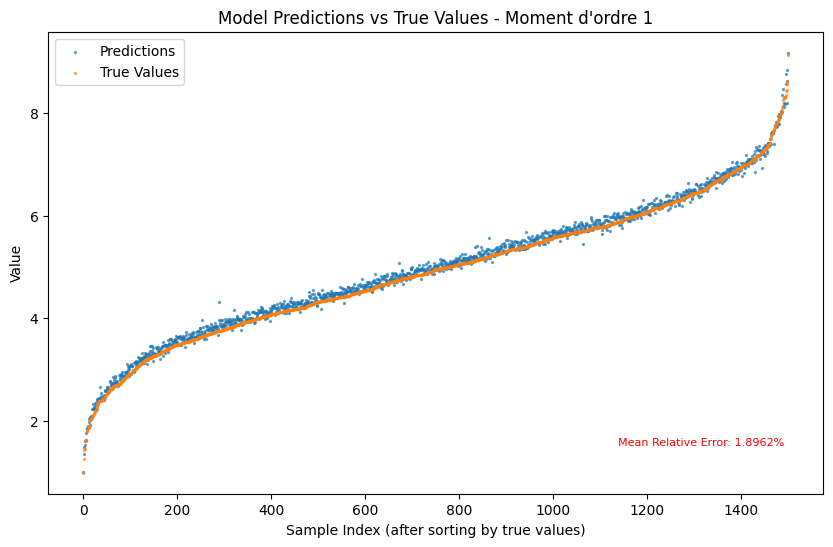

Mean Relative Error: 0.05290547261635462


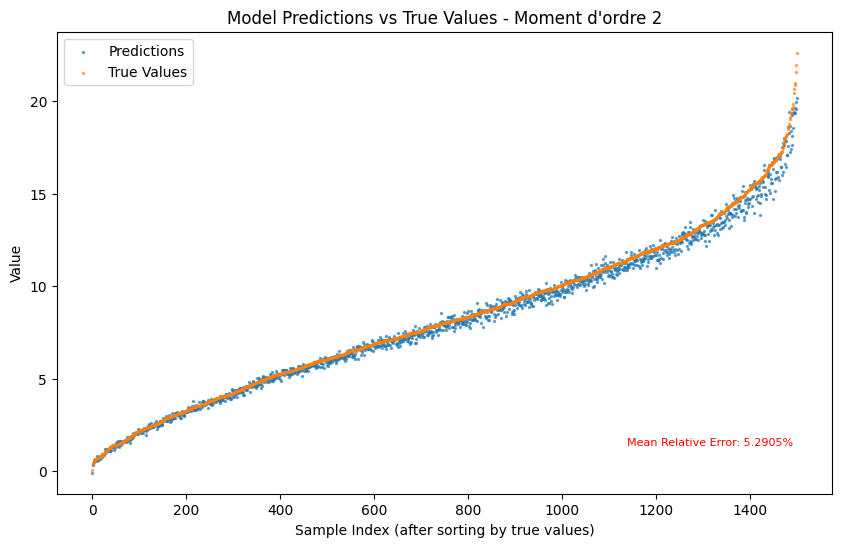

Mean Relative Error: 0.01944527487891416


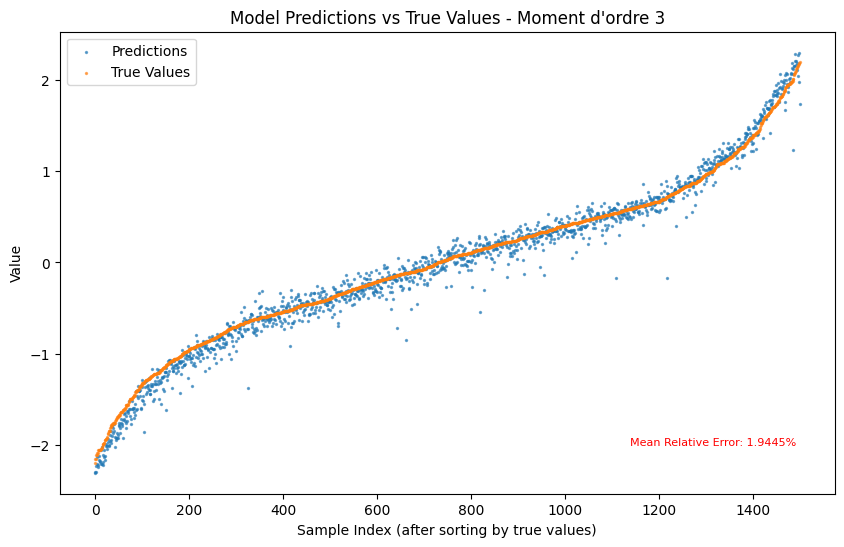

Mean Relative Error: 0.05443608853965998


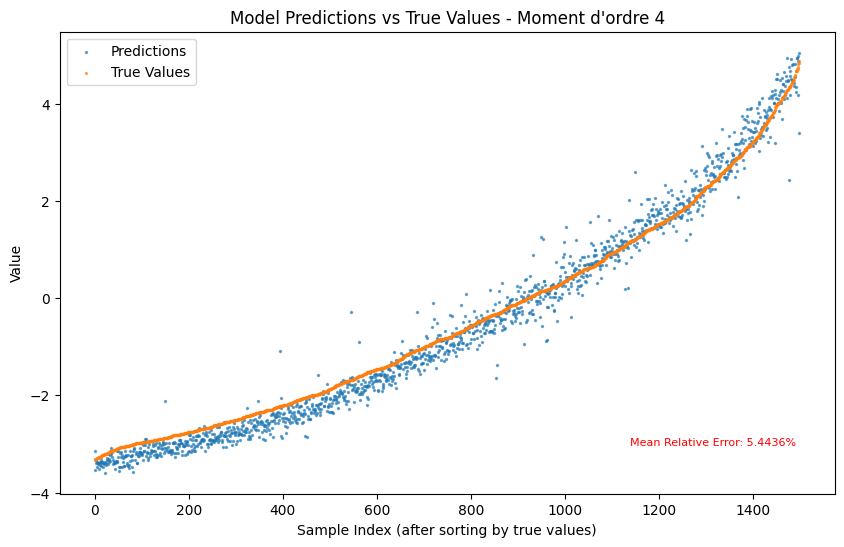

In [86]:
for i in range(0, 4):
    plot(i)